
# I Scraped Wikipedia to Build a Jungian-influenced Social Network Graph

A graph is a technique used by mathematicians and others to visualize relationships among members of a group. The word "Social" here does not have to do with social media, but rather the society of scientists and how older ideas change how younger scientists think about things.

Here I scrape Wikipedia for birth dates, and the **Influences** (upstream), and **Influenced** (downstream) links shown in the infobox. Here's the bottom of the infobox on Carl Jung's Wikipedia page for instance:<br />

<img src="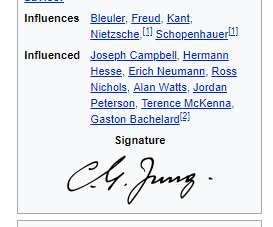&#10;">

Various Wikipedians add previous thinkers to the infobox that they feel represent the flow of ideas between these various people. From this information I created a graph with the directed edges created according to what people were influenced by who's research when developing their own research. In the above example, the arrows leading to the Carl Jung node in the graph below come from the people mentioned in the Influences section: Bleuler, Freud, Kant, Nietzsche, and Schopenhauer. The graph is in the shape of a tree with Carl Jung at the trunk. (While I was working on it, someone updated Jordan Peterson's page so that node got added also.)


# Load the various utility libraries

This is written as if you were running the notebook within a pull of my notebooks repository from a Microsoft Windows operating system.

In [1]:

%run ../../load_magic/storage.py
%who

DATA_FOLDER: ../data/
SAVES_FOLDER: ../saves/
DATA_FOLDER	 ENCODING_TYPE	 SAVES_FOLDER	 attempt_to_pickle	 load_csv	 load_dataframes	 load_object	 os	 pd	 
pickle	 save_dataframes	 store_objects	 


In [4]:

# Install the bs4 library
!pip install bs4 --upgrade --quiet

In [5]:

# Install the networkx library
!pip install networkx --upgrade --quiet

In [6]:

# Install the wikipedia library
!pip install wikipedia --upgrade --quiet


# Prepare the directional graph for adding nodes and edges to

In [8]:

from bs4 import BeautifulSoup as bs
import networkx as nx
import wikipedia
import re

jung_digraph = nx.DiGraph()
jung_title = 'Carl Jung'
node_list = [jung_title]
jung_digraph.add_node(jung_title)
jung_page = wikipedia.page(jung_title)
born_regex = re.compile(r'(\d{3,4}( BC)?)')
bc_regex = re.compile(r'(\d+) BC')
pos_dict = {}

This code in the cell below is just a hack to force networkx to distribute the nodes in a random way across 100 slots so as not to write the labels on top of one another.

In [10]:

from random import shuffle

y_supply = list(range(100))
shuffle(y_supply)

def y():
    
    return (y_supply.pop())


The code in the cell below is a hack to make the labels on the ticks on the x axis conform to actual dates:

In [2]:

# Install the numpy library
!pip install numpy --upgrade --quiet

In [3]:

import numpy as np

# Convert [-500, 0, 500, 1000, 1500, 2000] into [-500, 1750, ... 2000]
nominal_list = [-500, 0, 500, 1000, 1500, 2000]
xtick_list = [int(round(elem)) for elem in pd.cut(np.array([1750, 2000]), 4, retbins=True)[1]]
xtick_list = [-500] + xtick_list
def recalculate_born_year(born_year):
    if born_year < nominal_list[1]:
        pass
    elif born_year < xtick_list[1]:
        born_year = born_year - (xtick_list[1] - nominal_list[1])
    elif born_year < xtick_list[2]:
        born_year = born_year - (xtick_list[2] - nominal_list[2])
    elif born_year < xtick_list[3]:
        born_year = born_year - (xtick_list[3] - nominal_list[3])
    elif born_year < xtick_list[4]:
        born_year = born_year - (xtick_list[4] - nominal_list[4])
    
    return born_year

In [11]:

def spider_infoboxes(jung_digraph, jung_page, updown='both'):
    jung_soup = bs(jung_page.html(), 'lxml')
    jung_title = jung_page.title
    for param_th in jung_soup.find_all('th', scope='row'):
        if (param_th.text.strip()=='Baptised') or (param_th.text.strip()=='Born'):
            born_td = param_th.find_next_sibling('td')
            born_list = born_regex.findall(born_td.text)
            if len(born_list) > 0:
                born_x = max(born_list, key=lambda x: len(x[0]))[0]
                born_x = int(bc_regex.sub(r'-\1', born_x))
                born_x = recalculate_born_year(born_x)
                born_pos = np.array((born_x, y()))
                born_pos = born_pos.astype(np.float32)
                pos_dict[jung_title] = born_pos
        if (param_th.text.strip()=='Influences') and ((updown=='both') or (updown=='up')):
            influences_td = param_th.find_next_sibling('td')
            for influences_link in influences_td.find_all('a', title=True):
                influences_title = influences_link['title']
                
                # Compensate for redirects
                influences_page = wikipedia.page(influences_title)
                influences_title = influences_page.title
                
                if influences_title not in node_list:
                    jung_digraph.add_node(influences_title)
                jung_digraph.add_edge(influences_title, jung_title)
                if influences_title not in node_list:
                    jung_digraph = spider_infoboxes(jung_digraph, influences_page, updown='up')
                    node_list.append(influences_title)
        if (param_th.text.strip()=='Influenced') and ((updown=='both') or (updown=='down')):
            influenced_td = param_th.find_next_sibling('td')
            for influenced_link in influenced_td.find_all('a', title=True):
                influenced_title = influenced_link['title']
                
                # Compensate for redirects
                influenced_page = wikipedia.page(influenced_title)
                influenced_title = influenced_page.title
                
                if influenced_title not in node_list:
                    jung_digraph.add_node(influenced_title)
                jung_digraph.add_edge(jung_title, influenced_title)
                if influenced_title not in node_list:
                    jung_digraph = spider_infoboxes(jung_digraph, influenced_page, updown='down')
                    node_list.append(influenced_title)
    
    return jung_digraph


# Add the nodes and edges

And store the graph as a pickle so I don't have to keep on recreating it.

In [12]:

jung_digraph = spider_infoboxes(jung_digraph, jung_page)
store_objects(jung_digraph=jung_digraph)

Pickling to ../saves/pickle/jung_digraph.pickle



# Explore various graph visualizations

It turns out it is hard to create a visualization that lets you see each node an edge. For instance, here is the default spring layout:

In [13]:

# Install the matplotlib library
!pip install matplotlib --upgrade --quiet

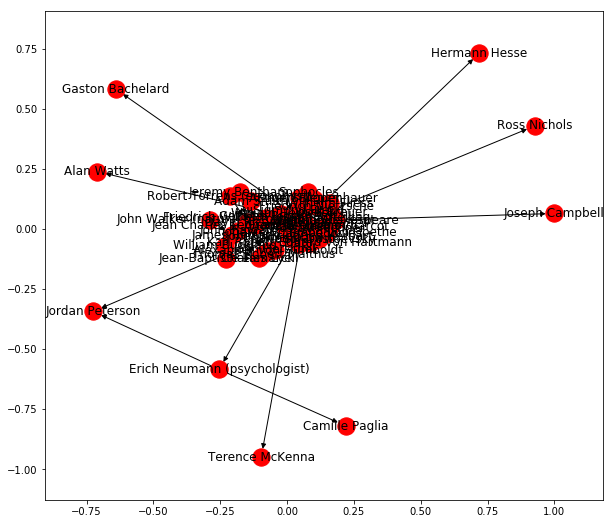

In [14]:

import matplotlib.pyplot as plt
%matplotlib inline

# Draw the graph using the default spring layout
plt.figure(figsize=(10,9))
nx.draw_networkx(jung_digraph)


Only a few nodes are visible. It doesn't change much if you run it again:

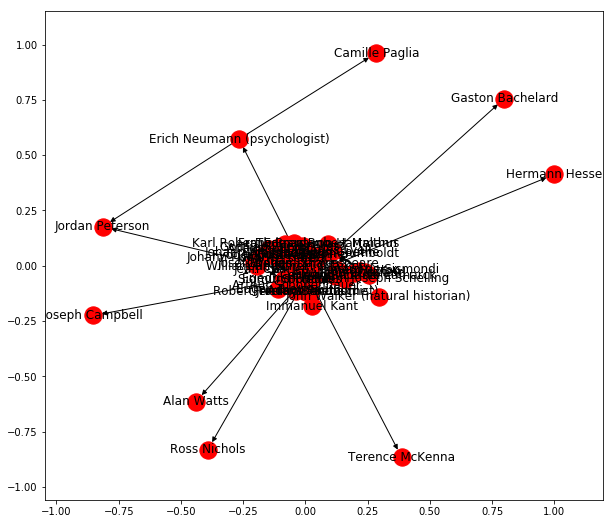

In [15]:

# Draw the graph using the spring layout
plt.figure(figsize=(10,9))
spring_pos = nx.spring_layout(jung_digraph)
nx.draw_networkx(jung_digraph, spring_pos)

Here is what it looks like if you use the circular layout:

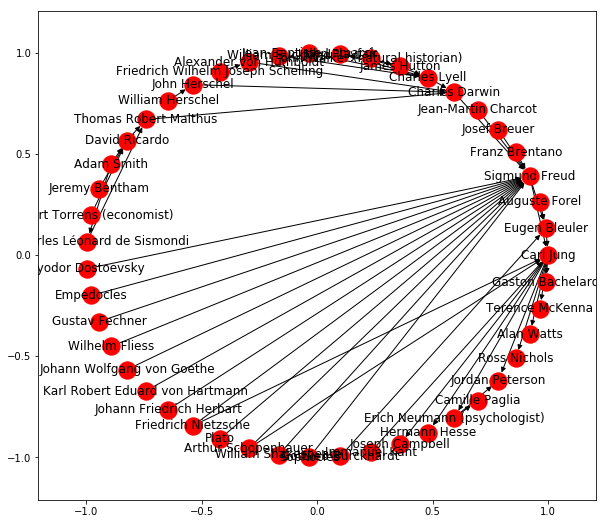

In [16]:

# Draw the graph using the circular layout
plt.figure(figsize=(10,9))
pos = nx.circular_layout(jung_digraph)
nx.draw_networkx(jung_digraph, pos)

The random layout is the clearest one so far.

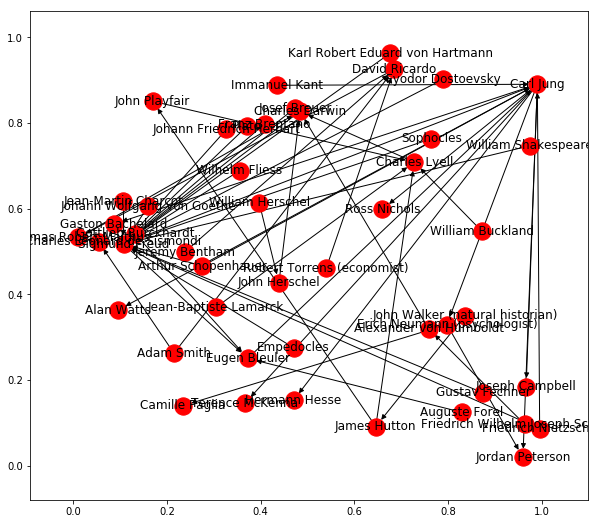

In [17]:

# Draw the graph using the random layout
plt.figure(figsize=(10,9))
pos = nx.random_layout(jung_digraph)
nx.draw_networkx(jung_digraph, pos)

The spectral layout is the worst!

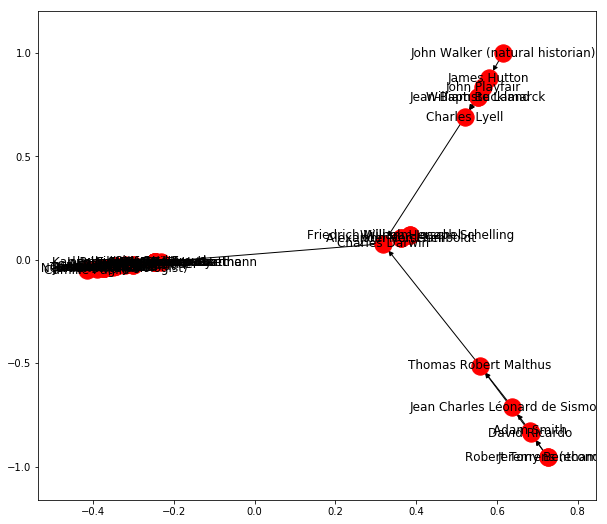

In [18]:

# Draw the graph using the spectral layout
plt.figure(figsize=(10,9))
pos = nx.spectral_layout(jung_digraph)
nx.draw_networkx(jung_digraph, pos)

The fruchterman reingold layout is only slightly better than the spring layout.

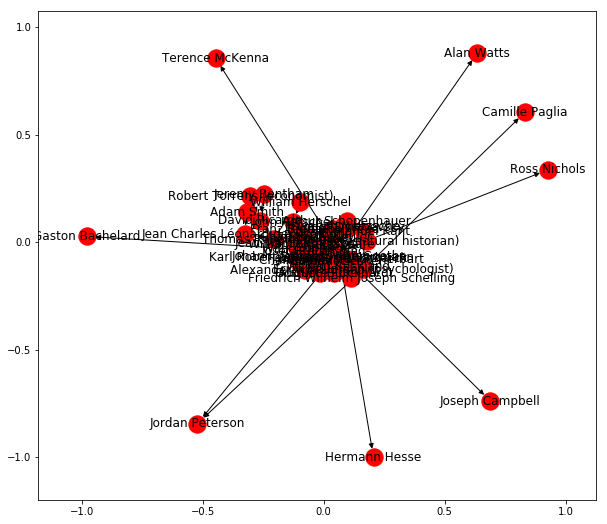

In [19]:

# Draw the graph using the fruchterman reingold layout
plt.figure(figsize=(10,9))
pos = nx.fruchterman_reingold_layout(jung_digraph)
nx.draw_networkx(jung_digraph, pos)

The kamada kawai layout is the best so far - let's use it's y dimensions and keep our birth-year-based x dimension as a layout to examine each generation of scientists as a subgraph.

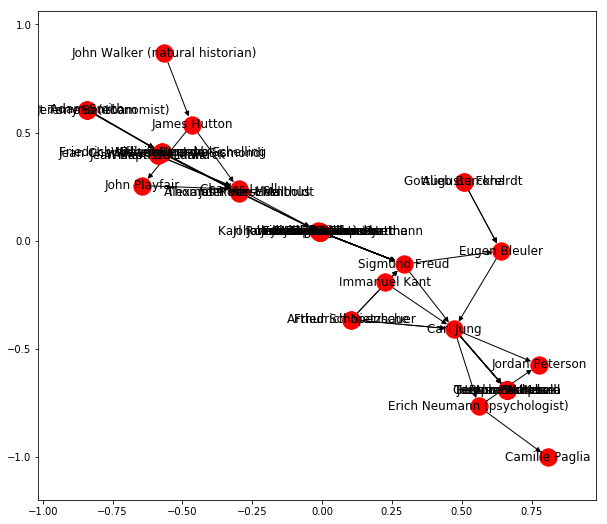

In [20]:

# Draw the graph using the kamada kawai layout
plt.figure(figsize=(10,9))
pos = nx.kamada_kawai_layout(jung_digraph)
nx.draw_networkx(jung_digraph, pos)

In [21]:

#pos_dict = load_object('pos_dict')
kamada_kawai_pos = nx.kamada_kawai_layout(jung_digraph)
for node in pos_dict:
    pos_dict[node] = np.array((pos_dict[node][0], kamada_kawai_pos[node][1])).astype(np.float32)
store_objects(pos_dict=pos_dict)

Pickling to ../saves/pickle/pos_dict.pickle


The first generation is what some Wikipedian preener added as influencing, of course, Sigmund Freud. They actually occupy two generations, but as outliers I don't want to deal with them much.

['Sophocles', 'Empedocles', 'Plato']


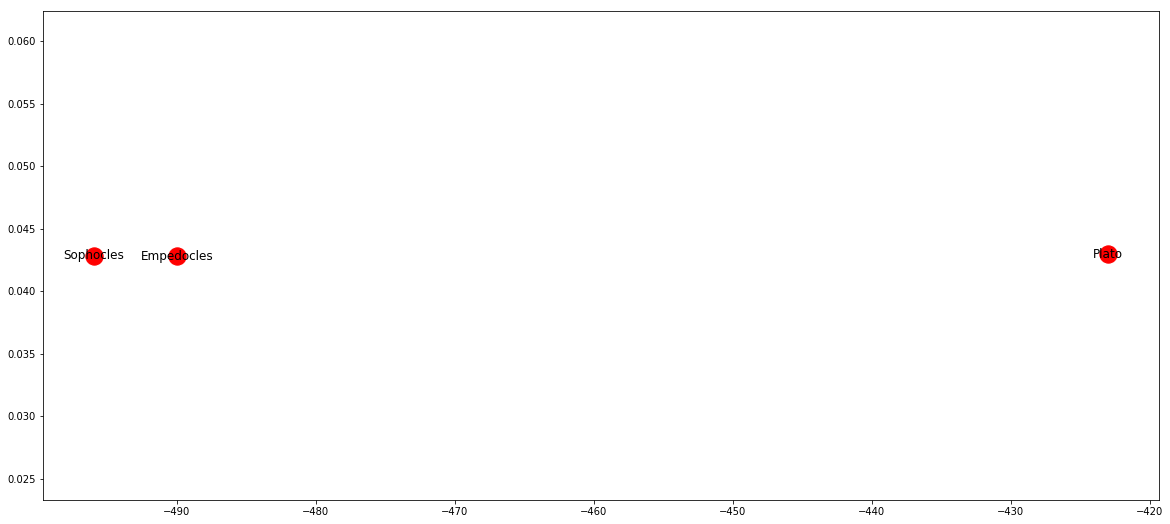

In [22]:

import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline

# Let's look at dudes based on their birth range
tuple_list = sorted(pos_dict.items(), key=lambda x: x[1][0])[:3]
jung_digraph = load_object('jung_digraph')
node_list = [node[0] for node in tuple_list]
jung_subgraph = jung_digraph.subgraph(node_list)
subgraph_fig = plt.figure(figsize=(20, 9))
subgraph_ax = subgraph_fig.add_subplot(111)
nx.draw_networkx(G=jung_subgraph, pos=pos_dict)
print(str(node_list))

The trick here is to widen the y space to -1.5 to 1.5 and cut that into 4 parts, using the last three to postion the three nodes

In [23]:

cut_array = pd.cut(np.array([-1.5, 1.5]), len(node_list)+1, retbins=True)[1]
for i, node in enumerate(node_list):
    pos_dict[node] = np.array((pos_dict[node][0], cut_array[i+1])).astype(np.float32)
store_objects(pos_dict=pos_dict)

Pickling to ../saves/pickle/pos_dict.pickle


The next generation again contains an outlier from Sigmund Freud, which I'm going to include with the rest. Same technique to place them in the y dimension as last time.

['William Shakespeare', 'Adam Smith', 'Immanuel Kant', 'James Hutton', 'John Walker (natural historian)', 'William Herschel', 'Jean-Baptiste Lamarck', 'John Playfair', 'Jeremy Bentham', 'Johann Wolfgang von Goethe']


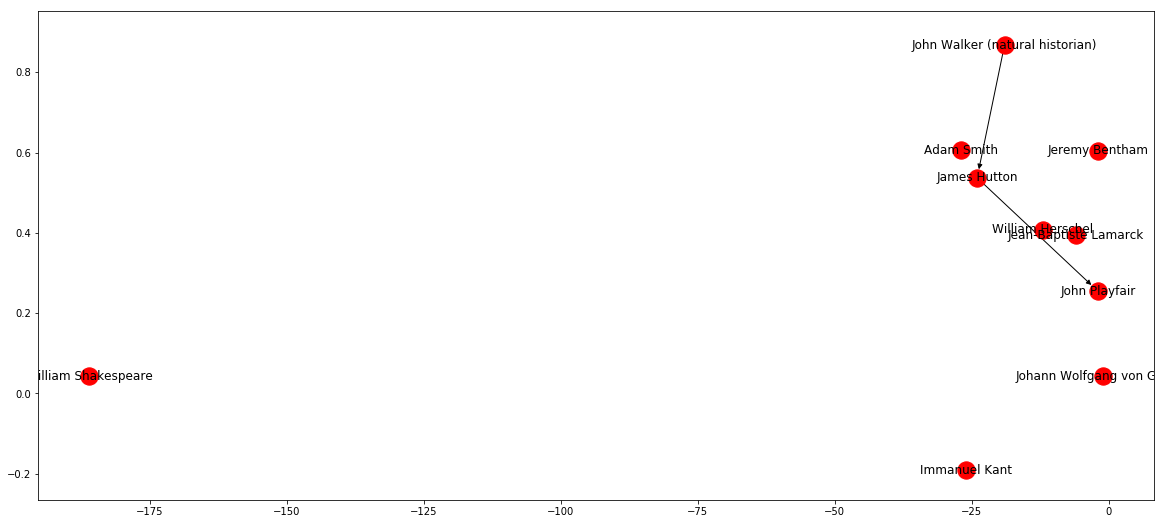

In [24]:

import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline

# Let's look at dudes based on their birth range
tuple_list = sorted(pos_dict.items(), key=lambda x: x[1][0])[3:13]
jung_digraph = load_object('jung_digraph')
node_list = [node[0] for node in tuple_list]
jung_subgraph = jung_digraph.subgraph(node_list)
subgraph_fig = plt.figure(figsize=(20, 9))
subgraph_ax = subgraph_fig.add_subplot(111)
nx.draw_networkx(G=jung_subgraph, pos=pos_dict)
print(str(node_list))

In [25]:

cut_array = pd.cut(np.array([-1.5, 1.5]), len(node_list)+1, retbins=True)[1]
for i, node in enumerate(node_list):
    pos_dict[node] = np.array((pos_dict[node][0], cut_array[i+1])).astype(np.float32)
store_objects(pos_dict=pos_dict)

Pickling to ../saves/pickle/pos_dict.pickle


['Thomas Robert Malthus', 'Alexander von Humboldt', 'David Ricardo', 'Jean Charles Léonard de Sismondi', 'Friedrich Wilhelm Joseph Schelling', 'Johann Friedrich Herbart', 'Robert Torrens (economist)', 'William Buckland', 'Arthur Schopenhauer', 'John Herschel', 'Charles Lyell', 'Gustav Fechner', 'Charles Darwin']


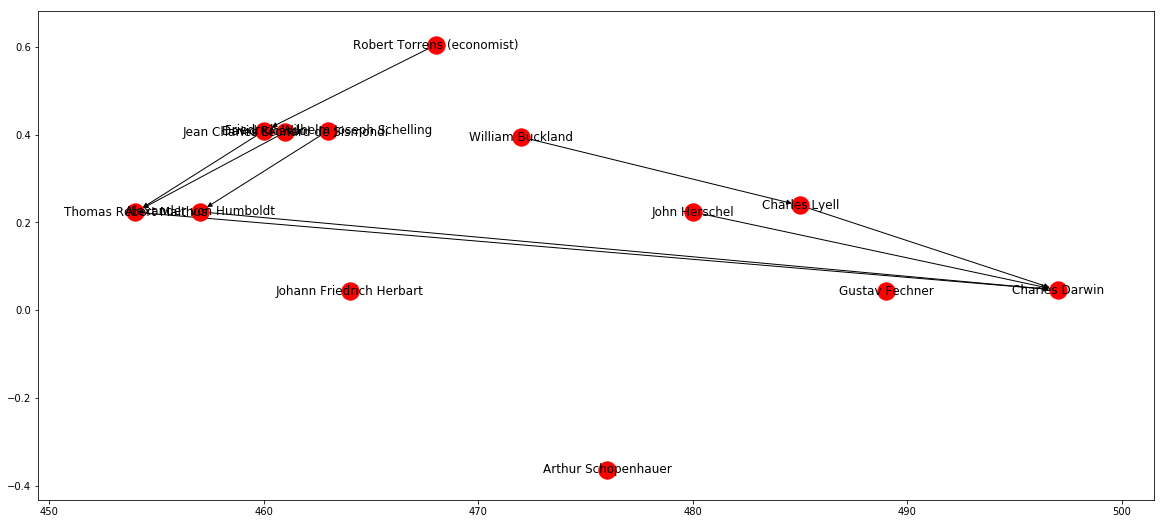

In [26]:

import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline

# Let's look at dudes based on their birth range
tuple_list = sorted(pos_dict.items(), key=lambda x: x[1][0])[13:26]
jung_digraph = load_object('jung_digraph')
node_list = [node[0] for node in tuple_list]
jung_subgraph = jung_digraph.subgraph(node_list)
subgraph_fig = plt.figure(figsize=(20, 9))
subgraph_ax = subgraph_fig.add_subplot(111)
nx.draw_networkx(G=jung_subgraph, pos=pos_dict)
print(str(node_list))

In [27]:

cut_array = pd.cut(np.array([-1.5, 1.5]), len(node_list)+1, retbins=True)[1]
for i, node in enumerate(node_list):
    pos_dict[node] = np.array((pos_dict[node][0], cut_array[i+1])).astype(np.float32)
store_objects(pos_dict=pos_dict)

Pickling to ../saves/pickle/pos_dict.pickle


Notice that I'm using magic numbers to determine the generational span (26:37 in the next case). I will fix this later using a clustering algorithm.

['Fyodor Dostoevsky', 'Jean-Martin Charcot', 'Gottlieb Burckhardt', 'Franz Brentano', 'Josef Breuer', 'Karl Robert Eduard von Hartmann', 'Friedrich Nietzsche', 'Auguste Forel', 'Sigmund Freud', 'Eugen Bleuler', 'Wilhelm Fliess']


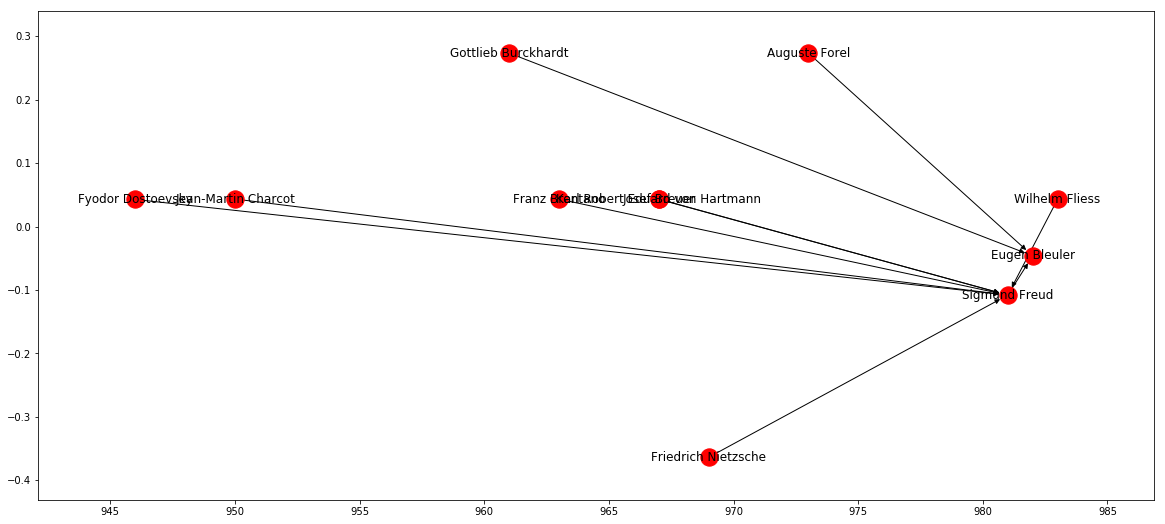

In [28]:

import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline

# Let's look at dudes based on their birth range
tuple_list = sorted(pos_dict.items(), key=lambda x: x[1][0])[26:37]
jung_digraph = load_object('jung_digraph')
node_list = [node[0] for node in tuple_list]
jung_subgraph = jung_digraph.subgraph(node_list)
subgraph_fig = plt.figure(figsize=(20, 9))
subgraph_ax = subgraph_fig.add_subplot(111)
nx.draw_networkx(G=jung_subgraph, pos=pos_dict)
print(str(node_list))

In [29]:

cut_array = pd.cut(np.array([-1.5, 1.5]), len(node_list)+1, retbins=True)[1]
for i, node in enumerate(node_list):
    pos_dict[node] = np.array((pos_dict[node][0], cut_array[i+1])).astype(np.float32)
store_objects(pos_dict=pos_dict)

Pickling to ../saves/pickle/pos_dict.pickle


Carl Jung is the trunk of the tree, so here he appears with the root nodes in his own generation.

['Carl Jung', 'Hermann Hesse', 'Gaston Bachelard', 'Ross Nichols', 'Joseph Campbell', 'Erich Neumann (psychologist)', 'Alan Watts']


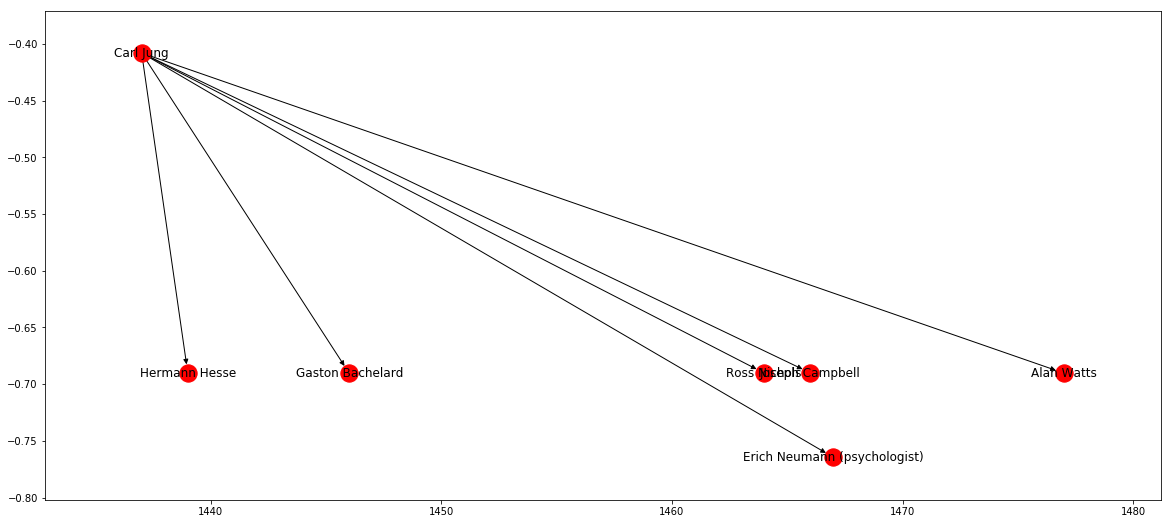

In [30]:

import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline

# Let's look at dudes based on their birth range
tuple_list = sorted(pos_dict.items(), key=lambda x: x[1][0])[37:44]
jung_digraph = load_object('jung_digraph')
node_list = [node[0] for node in tuple_list]
jung_subgraph = jung_digraph.subgraph(node_list)
subgraph_fig = plt.figure(figsize=(20, 9))
subgraph_ax = subgraph_fig.add_subplot(111)
nx.draw_networkx(G=jung_subgraph, pos=pos_dict)
print(str(node_list))

In [31]:

cut_array = pd.cut(np.array([-1.5, 1.5]), len(node_list)+1, retbins=True)[1]
for i, node in enumerate(node_list):
    pos_dict[node] = np.array((pos_dict[node][0], cut_array[i+1])).astype(np.float32)
store_objects(pos_dict=pos_dict)

Pickling to ../saves/pickle/pos_dict.pickle


Below are the modern scientists who have been influenced by Jung. Being edge cases they again are actually more than one generation.

['Terence McKenna', 'Camille Paglia', 'Jordan Peterson']


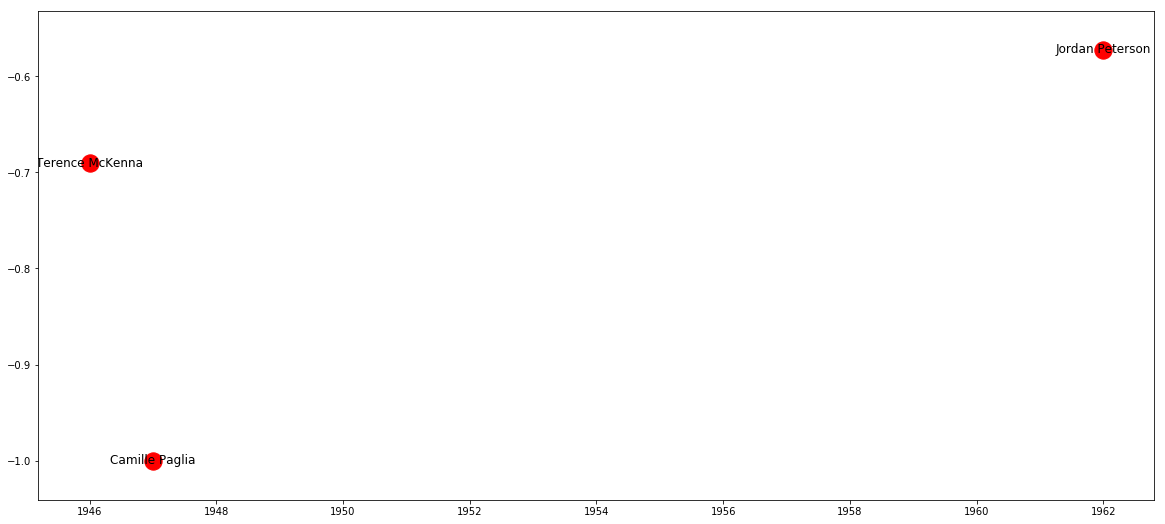

In [32]:

import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline

# Let's look at dudes based on their birth range
tuple_list = sorted(pos_dict.items(), key=lambda x: x[1][0])[44:47]
jung_digraph = load_object('jung_digraph')
node_list = [node[0] for node in tuple_list]
jung_subgraph = jung_digraph.subgraph(node_list)
subgraph_fig = plt.figure(figsize=(20, 9))
subgraph_ax = subgraph_fig.add_subplot(111)
nx.draw_networkx(G=jung_subgraph, pos=pos_dict)
print(str(node_list))

In [33]:

cut_array = pd.cut(np.array([-1.5, 1.5]), len(node_list)+1, retbins=True)[1]
for i, node in enumerate(node_list):
    pos_dict[node] = np.array((pos_dict[node][0], cut_array[i+1])).astype(np.float32)
store_objects(pos_dict=pos_dict)

Pickling to ../saves/pickle/pos_dict.pickle


Below is the same graph with the y axis spread according to what I did to each generation above.

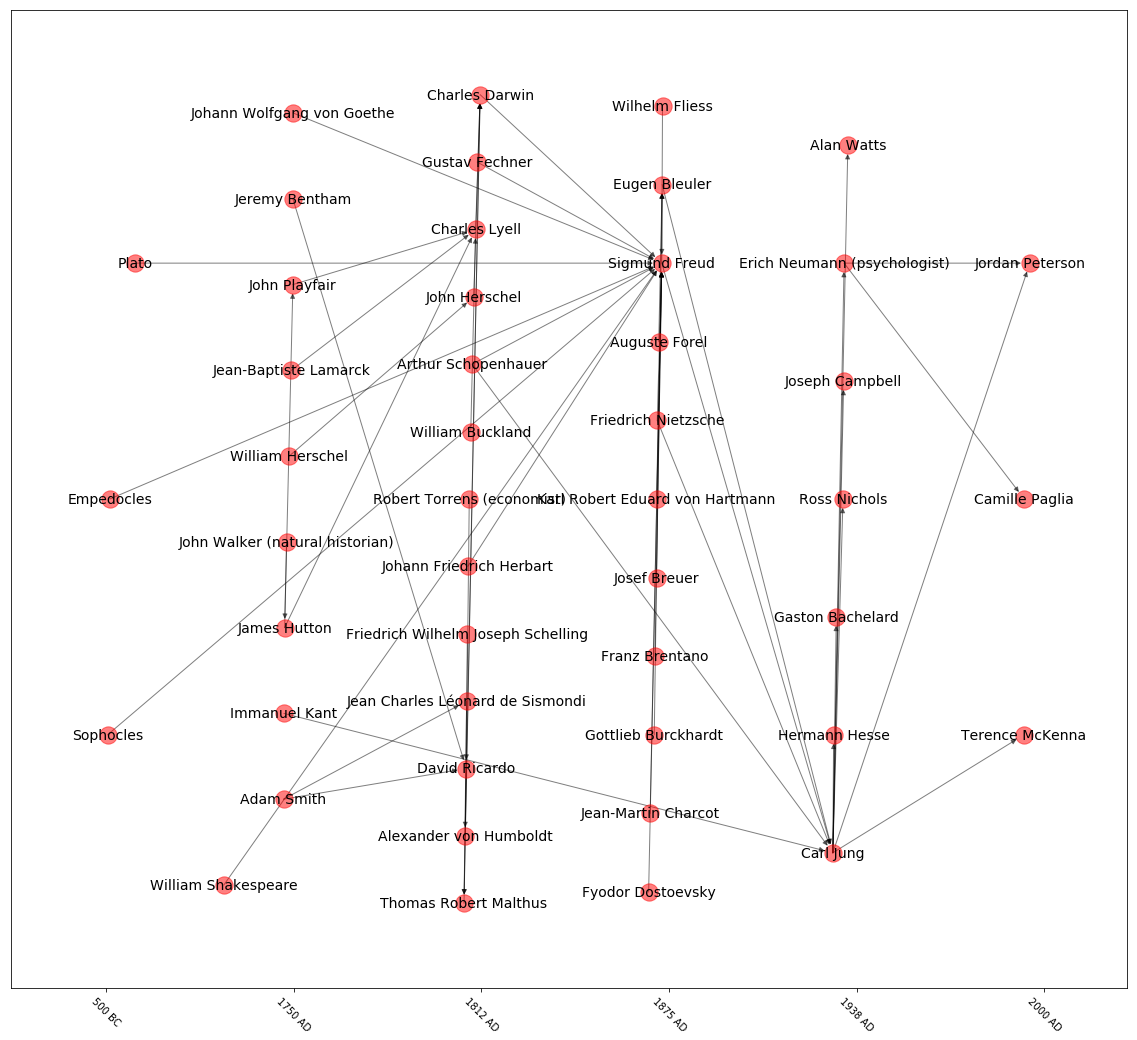

In [34]:

import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline

# Draw the graph using the birth-year-based layout
pos_dict = load_object('pos_dict')
jung_fig = plt.figure(figsize=(20, 18))
ax = jung_fig.add_subplot(111)
xticklabel_list = []
bc_regex = re.compile(r'-(\d+)')
for xtick in xtick_list:
    if xtick == 0:
        xticklabel_list.append('')
    elif xtick < 0:
        xticklabel_list.append(bc_regex.sub(r'\1 BC', str(xtick)))
    elif xtick > 0:
        xticklabel_list.append(str(xtick) + ' AD')
plt.xticks(nominal_list, xticklabel_list, rotation=-45)
plt.yticks([], [])
jung_digraph = load_object('jung_digraph')
node_collection = nx.draw_networkx_nodes(G=jung_digraph, pos=pos_dict, alpha=0.5)
edge_collection = nx.draw_networkx_edges(G=jung_digraph, pos=pos_dict, alpha=0.5)
labels_collection = nx.draw_networkx_labels(G=jung_digraph, pos=pos_dict, font_size=14)


The y axis is just for readability, but the x axis is birth year (with a big gap after 500 BC). It looks kind of like a sailing ship's masts and rigging! It's interesting that, at this time scale, the scientists occur in isolated generations and are not evenly spread through time.


# Limitations of this approach

## Technical problems

Any suggestions on node placement? Node color? I have to figure out some way to better display the generational connections. They just get jumbled together. Also, the arrows on the edges are hardly visible. That’s because the python library <code>networkx</code> is using the python library <code>matplotlib</code> to make the arrows, and arrows are difficult in <code>matplotlib</code>.


The limitation of only scraping the infobox is that if there isn’t an Influences section and Jung, his anscestor, or his descendent is not in it, that node won’t end up in my graph. On top of that, infoboxes for writers don't display the Influences section, even if someone added it. For instance, here is what it looks like when you edit the wikipedia page for Mircea Eliade (https://en.wikipedia.org/wiki/Mircea_Eliade):

The infobox looks like this:

    {{Infobox writer
    | name        = Mircea Eliade
    | image       = Mircea.eliade.jpg
    | caption     = 
    | parents = Gheorghe Eliade <br/>Jeana née Vasilescu
    | birth_date  = {{birth date|1907|3|9}}
    | birth_place = [[Bucharest]], [[Kingdom of Romania|Romania]]
    | death_date  = {{death date and age|1986|4|22|1907|3|9}}
    | death_place = [[Chicago]], [[Illinois]], United States
    | occupation  = [[Historian]], [[philosopher]], [[short story writer]], [[journalist]], [[essayist]], [[novelist]]
    | nationality = Romanian
    | period      = 1921–1986
    | genre       = [[Fantasy literature|Fantasy]], [[autobiography]], [[travel literature]]
    | subject     = [[History of religion]], [[philosophy of religion]], [[cultural history]], [[political history]]
    | movement    = [[Modernism]]<br />''[[Criterion (literary society)|Criterion]]''<br />''Tr?irism''
    | influences  = [[Honoré de Balzac]], [[Surendranath Dasgupta]], [[Julius Evola]], [[James George Frazer]], [[André Gide]], [[René Guénon]], [[Bogdan Petriceicu Hasdeu]], [[Aldous Huxley]], [[Nae Ionescu]], [[Nicolae Iorga]], [[Carl Jung]], [[Rudolf Otto]], [[Giovanni Papini]], [[Gerardus van der Leeuw]], [[Miguel de Unamuno]], [[Joachim Wach]]
    | influenced  = [[Mihail (Marcel) Avramescu|Marcel Avramescu]], [[Ioan Petru Culianu]], [[Wendy Doniger]], [[Andrei Oi?teanu]], [[Mariana ?ora]], [[Mihail ?ora]]
    | signature   =
    | website     =
    }}

Look specifically at the Influences section:

    influences  = [[Honoré de Balzac]], [[Surendranath Dasgupta]], [[Julius Evola]], [[James George Frazer]], [[André Gide]], [[René Guénon]], [[Bogdan Petriceicu Hasdeu]], [[Aldous Huxley]], [[Nae Ionescu]], [[Nicolae Iorga]], [[Carl Jung]], [[Rudolf Otto]], [[Giovanni Papini]], [[Gerardus van der Leeuw]], [[Miguel de Unamuno]], [[Joachim Wach]]

Notice how Carl Jung is already in there. The problem is that the writer infobox doesn't display the influences or influenced, and the <code>wikipedia</code> scraper won't pick it up.


## Social problems

According to [/u/mherick](https://www.reddit.com/user/mherick), in terms of actual influence and change in persona or ideological stance, its limited by, at best, tangental reference. For instance, McKenna read Jung. Just read. And it really wasn't in-depth study or communication with. So its a cool model that might have pretty interesting uses but in terms or something academically useful its less than substantial.

Indeed, the academic utility is hampered by Wikipedia itself. The problem with mining the consensus of Wikipedians is a kind of [/r/imasosmart](https://www.reddit.com/r/iamsosmart/) virtue signalling (or intellectual preening) going on. The same pathological tendency that makes people coincidentally choose the theory of relativity as what they brag about being smart at, makes Wikipedians want to add Sophocles, Empedocles, Plato, and William Shakespeare as influencing Freud.

Compare the relatively impractical-for-signalling Terence McKenna:

In [35]:

# https://www.reddit.com/r/Jung/comments/8105jh/i_scraped_wikipedia_to_build_jungian_influence/duzirxw/
for node in nx.all_neighbors(jung_digraph, 'Terence McKenna'):
    print(node)

Carl Jung


With the everybody-can-see-me-from-here Sigmund Freud:

In [36]:

# https://www.reddit.com/r/Jung/comments/8105jh/i_scraped_wikipedia_to_build_jungian_influence/duzirxw/
for node in nx.all_neighbors(jung_digraph, 'Sigmund Freud'):
    print(node)

Franz Brentano
Josef Breuer
Jean-Martin Charcot
Charles Darwin
Fyodor Dostoevsky
Empedocles
Gustav Fechner
Wilhelm Fliess
Johann Wolfgang von Goethe
Karl Robert Eduard von Hartmann
Johann Friedrich Herbart
Friedrich Nietzsche
Plato
Arthur Schopenhauer
William Shakespeare
Sophocles
Eugen Bleuler
Carl Jung



### Extra Credit: Kamada Kawai Layout

The kamada kawai layout looks cool - how about we keep the x coordinates of the kamada kawai positions and redistribute the y coordinates so that the labels in the node bunches can be read?

DATA_FOLDER: ../data/
SAVES_FOLDER: ../saves/


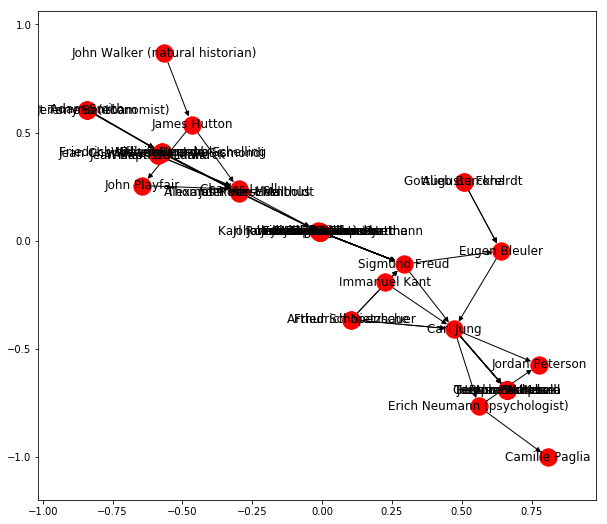

In [37]:

import networkx as nx
import matplotlib.pyplot as plt
%run ../../load_magic/storage.py
%matplotlib inline

# Draw the graph using the kamada kawai layout
jung_digraph = load_object('jung_digraph')
plt.figure(figsize=(10,9))
kamada_kawai_layout_dict = nx.kamada_kawai_layout(jung_digraph)
nx.draw_networkx(jung_digraph, kamada_kawai_layout_dict)

We'll put the xy coordinates in a pandas dataframe so that we can easily perform clustering, group by the clusters, and assign each its own place in the y dimension.

In [38]:

rows_list = []
for key, value in kamada_kawai_layout_dict.items():
    
    # Get input row in dictionary format; key = col_name
    row_dict = {}
    row_dict['node'] = key
    row_dict['x'] = value[0]
    row_dict['y'] = value[1]
    
    rows_list.append(row_dict)

kamada_kawai_df = pd.DataFrame(rows_list, columns=['node', 'x', 'y'])
kamada_kawai_df.sample(n=10)

,node,x,y
13,William Buckland,-0.588027,0.394751
27,Wilhelm Fliess,-0.007292,0.042988
34,William Shakespeare,-0.007411,0.042892
33,Arthur Schopenhauer,0.103590,-0.364050
14,Alexander von Humboldt,-0.295991,0.224366
39,Hermann Hesse,0.662523,-0.690083
22,Robert Torrens (economist),-0.842236,0.604534
7,Charles Darwin,-0.016425,0.045774
41,Camille Paglia,0.808713,-1.000000
28,Johann Wolfgang von Goethe,-0.007296,0.042985


In [39]:

# Install the sklearn library
!pip install sklearn --upgrade --quiet

17 [ 0  1  2  3  4  4  4  4  5  6  7  8  9  9  5  9  5  9  5  9 10 10 10  9
  4  4  4  4  4  4  4 11  4 11  4  4  2 12 13 13 14 15 16 13 13 13 13]


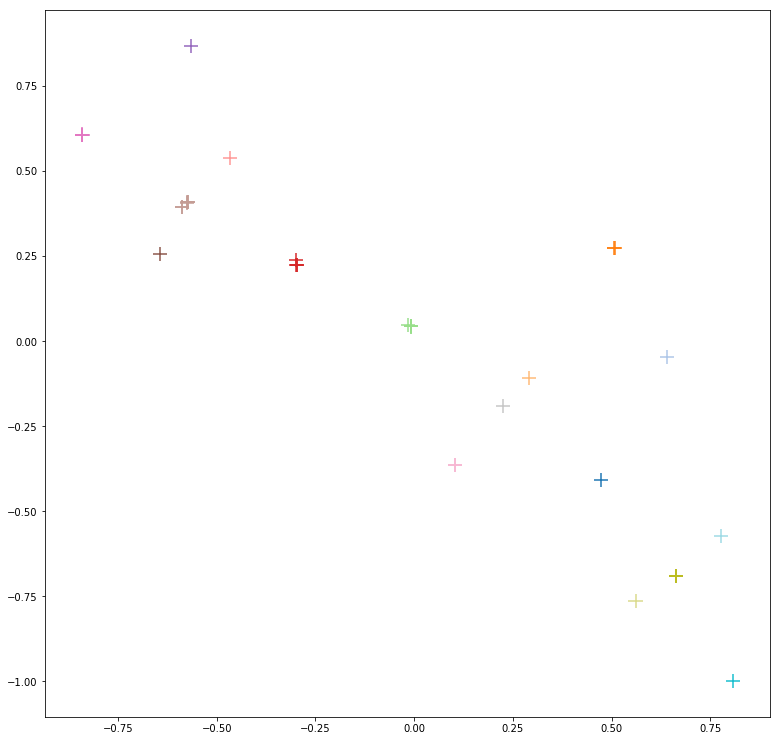

In [40]:

from sklearn.cluster import DBSCAN

# Dropping any missing coordinates: neccessary for DBSCAN to work
elite_df = kamada_kawai_df.dropna(how='any').copy()
column_list = ['x', 'y']
elite_ndarray = elite_df[column_list].values

# The maximum distance between two samples for them to be considered
# as in the same neighborhood.
eps = .03

# The number of samples (or total weight) in a neighborhood for a point
# to be considered as a core point. This includes the point itself.
min_samples = 1

# Compute DBSCAN
db = DBSCAN(eps=eps, min_samples=min_samples).fit(elite_ndarray)
labels = db.labels_

# Display the clusters as plus signs grouped by color
fig = plt.figure(figsize=(13, 13))
ax = fig.add_subplot(111, autoscale_on=True)
cmap = plt.get_cmap('tab20')
path_collection = ax.scatter(elite_ndarray[:, 0], elite_ndarray[:, 1],
                             c=labels, marker='+', s=200,
                             edgecolors=(0, 0, 0), cmap=cmap)

# Looking for 17 clusters by human count
print(len(set(labels)), labels)

In [41]:

# Add the cluster labels to the dataframe
elite_df['label'] = labels
elite_df.sample(n=10)

,node,x,y,label
23,Jean Charles Léonard de Sismondi,-0.575649,0.406325,9
11,John Playfair,-0.643716,0.255312,8
4,Franz Brentano,-0.007148,0.043199,4
25,Empedocles,-0.007433,0.042785,4
45,Terence McKenna,0.662287,-0.690278,13
37,Immanuel Kant,0.225376,-0.191972,12
21,Jeremy Bentham,-0.842228,0.604732,10
8,Charles Lyell,-0.298562,0.238750,5
18,Thomas Robert Malthus,-0.298301,0.223229,5
44,Alan Watts,0.662327,-0.690245,13


In [42]:

# Add cluster dimensionality to the dataframe
label_groupby = elite_df.groupby(by='label', axis=0, sort=False)

# Grab each cluster and get its edge count
def f(df):
    node_list = df['node'].tolist()
    
    return len(jung_digraph.edges(nbunch=node_list))

# We care only about the output
dimension_series = label_groupby.apply(f)
dimension_dict = dimension_series.to_dict()
elite_df['dimensions'] = elite_df['label'].map(lambda x: dimension_dict[x])
elite_df.sample(n=10)

,node,x,y,label,dimensions
2,Auguste Forel,0.507592,0.273523,2,2
20,Adam Smith,-0.840188,0.606800,10,4
17,William Herschel,-0.573301,0.407868,9,6
40,Erich Neumann (psychologist),0.560840,-0.764512,14,2
39,Hermann Hesse,0.662523,-0.690083,13,0
3,Sigmund Freud,0.291561,-0.108111,3,2
27,Wilhelm Fliess,-0.007292,0.042988,4,14
11,John Playfair,-0.643716,0.255312,8,1
21,Jeremy Bentham,-0.842228,0.604732,10,4
33,Arthur Schopenhauer,0.103590,-0.364050,11,4


In [45]:

from collections import Counter
from itertools import count

# Get counts of each element in the list
elite_df = elite_df.sort_values(['dimensions', 'label'], ascending=[True, True]).reset_index(drop=True)
old_list = elite_df['label'].tolist()
print(old_list)


# From https://stackoverflow.com/questions/27265824/how-to-renumber-reverse-sorted-list-of-integers
def enumerate_unique(iterable):
    seen = {}
    counter = 0

    for x in iterable:
        i = seen.get(x)

        if i is None:
            seen[x] = counter
            yield counter
            counter += 1
        else:
            yield i

# Retrieve a sorted list from the new counter
new_list = list(enumerate_unique(old_list))
print(new_list)
elite_df['label'] = pd.Series(new_list)
elite_df.sample(n=10)

[13, 13, 13, 13, 13, 13, 15, 16, 1, 7, 8, 12, 2, 2, 3, 6, 14, 5, 5, 5, 5, 10, 10, 10, 11, 11, 9, 9, 9, 9, 9, 9, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[0, 0, 0, 0, 0, 0, 1, 2, 3, 4, 5, 6, 7, 7, 8, 9, 10, 11, 11, 11, 11, 12, 12, 12, 13, 13, 14, 14, 14, 14, 14, 14, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16]


,node,x,y,label,dimensions
40,Wilhelm Fliess,-0.007292,0.042988,16,14
32,Carl Jung,0.472683,-0.407949,15,8
34,Josef Breuer,-0.007115,0.043245,16,14
35,Jean-Martin Charcot,-0.007077,0.043297,16,14
26,Jean-Baptiste Lamarck,-0.588255,0.394780,14,6
44,Plato,-0.007336,0.042968,16,14
2,Ross Nichols,0.662362,-0.690215,0,0
8,Eugen Bleuler,0.640368,-0.046264,3,1
7,Jordan Peterson,0.776674,-0.572276,2,0
22,Jeremy Bentham,-0.842228,0.604732,12,4


In [46]:

import numpy as np

# Group by the cluster labels
label_groupby = elite_df.groupby(by='label')
kamada_kawai_layout_dict = nx.kamada_kawai_layout(jung_digraph)
node_count = len(kamada_kawai_layout_dict)

# Compensate here for the fact that the Jung node appears twice?
y_position_list = list(range(node_count+1))

# Grab each cluster, spread out its nodes, and assign them to their postions
label_list = []
def f(df):
    label = df['label'].tolist()[0]
    
    # For some reason the group by apply repeats the first group
    if label not in label_list:
        node_list = df['node'].tolist()
        cut_array = pd.cut(np.array([0, node_count]), len(node_list)+1, retbins=True)[1]
        for i, node in enumerate(node_list):

            # Find the y position from the list that is closest to the cut
            y_coord = min(y_position_list, key=lambda x: abs(x-cut_array[i+1]))

            kamada_kawai_layout_dict[node] = np.array((kamada_kawai_layout_dict[node][0], y_coord)).astype(np.float32)
            y_position_list.remove(y_coord)
        label_list.append(label)
    
    return label

# We care only about the side effect, not the output
_ = label_groupby.apply(f)

So the nodes are now positioned so you can read the labels. Notice how the nodes are running out of y postions from the list so that by the time you get to the last placements, the nodes are picking positions off the extremes. Sorting the node placement order by largest total dimension first (Freud) had no effect, but reversing that placement order had Peterson in the middle and Freud's nodes thrown out to the top and bottom. Also, I've discovered that the programmers of <code>matplotlib</code> have added a patch to handle arrows better! I've used this to make the edges thinner and the arrow heads bigger.

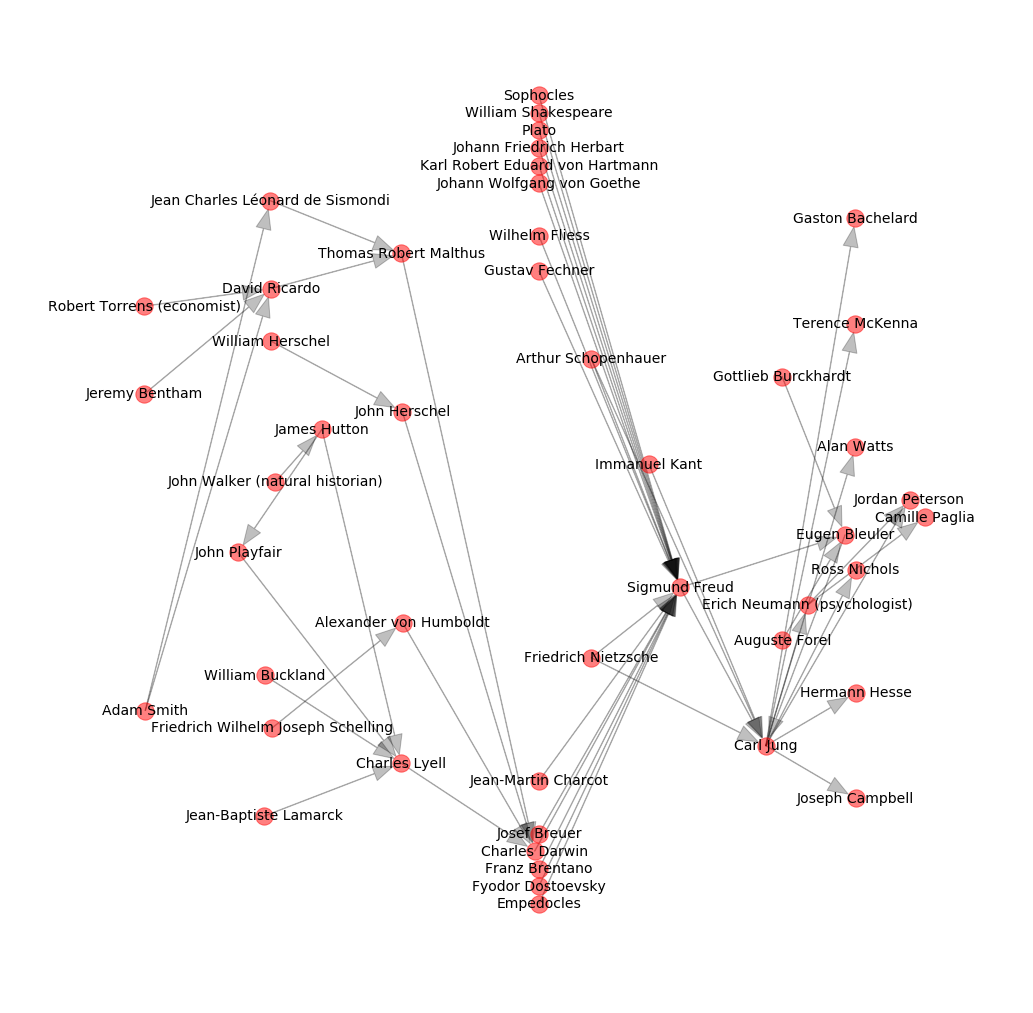

In [47]:

import matplotlib.patches as mpatches

kamada_kawai_fig = plt.figure(figsize=(18, 18))
plt.axis('off')
plt.yticks([], [])
arrowstyle = mpatches.ArrowStyle.Simple(head_length=2., head_width=1.5, tail_width=0.05)
node_collection = nx.draw_networkx_nodes(G=jung_digraph, pos=kamada_kawai_layout_dict, alpha=0.5)
edge_collection = nx.draw_networkx_edges(G=jung_digraph, pos=kamada_kawai_layout_dict, alpha=0.25, arrowstyle=arrowstyle)
labels_collection = nx.draw_networkx_labels(G=jung_digraph, pos=kamada_kawai_layout_dict, font_size=14)
axes_subplot = kamada_kawai_fig.get_axes()[0]
xlim_tuple = axes_subplot.set_xlim(left=-1.125, right=1)

In [48]:

import networkx as nx
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from collections import Counter
from itertools import count
import numpy as np
import matplotlib.patches as mpatches
%run ../../load_magic/storage.py
%matplotlib inline

def create_modified_kamada_kawai_plot(jung_digraph=None):
    '''
    We'll put the xy coordinates in a pandas dataframe so that we can easily perform
    clustering, group by the clusters, and assign each its own place in the y
    dimension.
    '''
    # Get the inital graph and layout
    if jung_digraph is None:
        jung_digraph = load_object('jung_digraph')
    kamada_kawai_layout_dict = nx.kamada_kawai_layout(jung_digraph)
    
    # Create a dataframe of the layout for clustering
    rows_list = []
    for key, value in kamada_kawai_layout_dict.items():

        # Get input row in dictionary format; key = col_name
        row_dict = {}
        row_dict['node'] = key
        row_dict['x'] = value[0]
        row_dict['y'] = value[1]

        rows_list.append(row_dict)

    kamada_kawai_df = pd.DataFrame(rows_list, columns=['node', 'x', 'y'])
    kamada_kawai_df.sample(n=10)
    
    # Drop any missing coordinates: neccessary for DBSCAN to work
    elite_df = kamada_kawai_df.dropna(how='any').copy()
    column_list = ['x', 'y']
    elite_ndarray = elite_df[column_list].values

    # The maximum distance between two samples for them to be considered
    # as in the same neighborhood.
    eps = .03

    # The number of samples (or total weight) in a neighborhood for a point
    # to be considered as a core point. This includes the point itself.
    min_samples = 1

    # Compute the DBSCAN labels and add them to the dataframe
    elite_df['label'] = DBSCAN(eps=eps, min_samples=min_samples).fit(elite_ndarray).labels_
    
    # Add cluster dimensionality to the dataframe
    label_groupby = elite_df.groupby(by='label', axis=0, sort=False)

    # Grab each cluster and get its edge count
    def f(df):
        node_list = df['node'].tolist()

        return len(jung_digraph.edges(nbunch=node_list))

    # We care only about the output
    dimension_dict = label_groupby.apply(f).to_dict()
    elite_df['dimensions'] = elite_df['label'].map(lambda x: dimension_dict[x])

    # Get counts of each element in the list
    elite_df = elite_df.sort_values(['dimensions', 'label'], ascending=[True, True]).reset_index(drop=True)
    old_list = elite_df['label'].tolist()

    # From https://stackoverflow.com/questions/27265824/how-to-renumber-reverse-sorted-list-of-integers
    def enumerate_unique(iterable):
        seen = {}
        counter = 0

        for x in iterable:
            i = seen.get(x)

            if i is None:
                seen[x] = counter
                yield counter
                counter += 1
            else:
                yield i

    # Retrieve a sorted list from the new counter
    new_list = list(enumerate_unique(old_list))
    elite_df['label'] = pd.Series(new_list)

    # Group by the cluster labels
    label_groupby = elite_df.groupby(by='label')
    node_count = len(kamada_kawai_layout_dict)

    # Compensate here for the fact that the Jung node appears twice?
    y_position_list = list(range(node_count+1))

    # Grab each cluster, spread out its nodes, and assign them to their postions
    label_list = []
    def f(df):
        label = df['label'].tolist()[0]

        # For some reason the groupby.apply repeats the first group
        if label not in label_list:
            node_list = df['node'].tolist()
            cut_array = pd.cut(np.array([0, node_count]), len(node_list)+1, retbins=True)[1]
            for i, node in enumerate(node_list):

                # Find the y position from the list that is closest to the cut
                y_coord = min(y_position_list, key=lambda x: abs(x-cut_array[i+1]))

                kamada_kawai_layout_dict[node] = np.array((kamada_kawai_layout_dict[node][0], y_coord)).astype(np.float32)
                y_position_list.remove(y_coord)
            label_list.append(label)

        return label

    # We care only about the side effect, not the output
    _ = label_groupby.apply(f)


    # So the nodes are now positioned so you can read the labels. Notice how the nodes
    # are running out of y postions from the list so that by the time you get to the
    # last placements, the nodes are picking positions off the extremes. Sorting the
    # node placement order by largest total dimension first (Freud) had no effect, but
    # reversing that placement order had Peterson in the middle and Freud's nodes
    # thrown out to the top and bottom. Also, I've discovered that the programmers of
    # <code>matplotlib</code> have added a patch to handle arrows better! I've used
    # this to make the edges thinner and the arrow heads
    # bigger.
    kamada_kawai_fig = plt.figure(figsize=(18, 18))
    plt.axis('off')
    plt.yticks([], [])
    arrowstyle = mpatches.ArrowStyle.Simple(head_length=2., head_width=1.5, tail_width=0.05)
    node_collection = nx.draw_networkx_nodes(G=jung_digraph, pos=kamada_kawai_layout_dict, alpha=0.5)
    edge_collection = nx.draw_networkx_edges(G=jung_digraph, pos=kamada_kawai_layout_dict, alpha=0.25, arrowstyle=arrowstyle)
    labels_collection = nx.draw_networkx_labels(G=jung_digraph, pos=kamada_kawai_layout_dict, font_size=14)
    axes_subplot = kamada_kawai_fig.get_axes()[0]
    xlim_tuple = axes_subplot.set_xlim(left=-1.125, right=1)

DATA_FOLDER: ../data/
SAVES_FOLDER: ../saves/


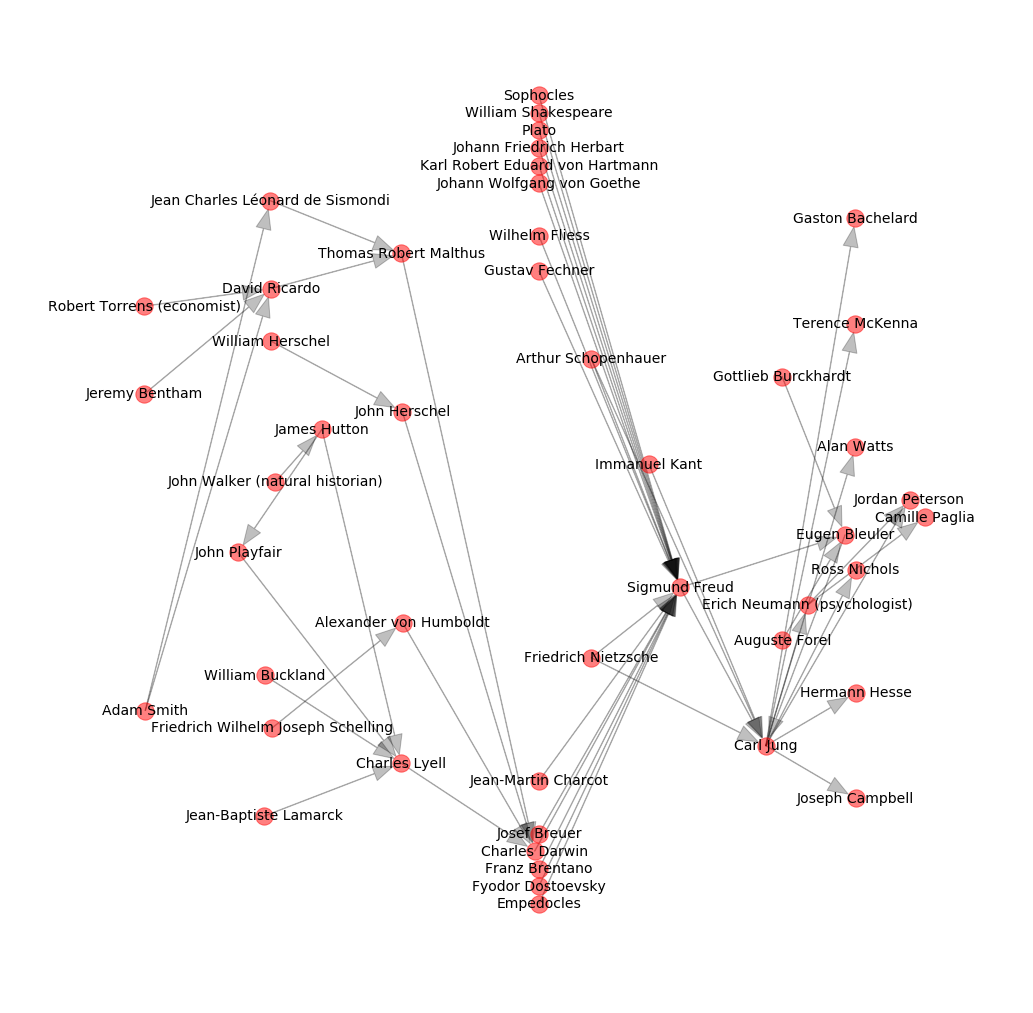

In [49]:

create_modified_kamada_kawai_plot(jung_digraph=None)


Now would be a good time to scrape wikipedia again to see if there are new edges between our node list.

In [50]:

from bs4 import BeautifulSoup as bs
import networkx as nx
import wikipedia

node_list = jung_digraph.nodes()
edge_list = jung_digraph.edges()
for jung_title in node_list:
    jung_page = wikipedia.page(jung_title)
    jung_soup = bs(jung_page.html(), 'lxml')
    for param_th in jung_soup.find_all('th', scope='row'):
        if (param_th.text.strip()=='Influences'):
            influences_td = param_th.find_next_sibling('td')
            for influences_link in influences_td.find_all('a', title=True):
                
                # Compensate for redirects
                influences_title = influences_link['title']
                try:
                    influences_page = wikipedia.page(influences_title)
                    influences_title = influences_page.title

                    if influences_title in node_list:
                        if (influences_title, jung_title) not in edge_list:
                            jung_digraph.add_edge(influences_title, jung_title)
                except Exception as e:
                    print(e)
        if (param_th.text.strip()=='Influenced'):
            influenced_td = param_th.find_next_sibling('td')
            for influenced_link in influenced_td.find_all('a', title=True):
                
                # Compensate for redirects
                influenced_title = influenced_link['title']
                try:
                    influenced_page = wikipedia.page(influenced_title)
                    influenced_title = influenced_page.title

                    if influenced_title in node_list:
                        if (jung_title, influenced_title) not in edge_list:
                            jung_digraph.add_edge(jung_title, influenced_title)
                except Exception as e:
                    print(e)
store_objects(jung_digraph=jung_digraph)

Page id "list of psychoanalysis" does not match any pages. Try another id!
Pickling to ../saves/pickle/jung_digraph.pickle


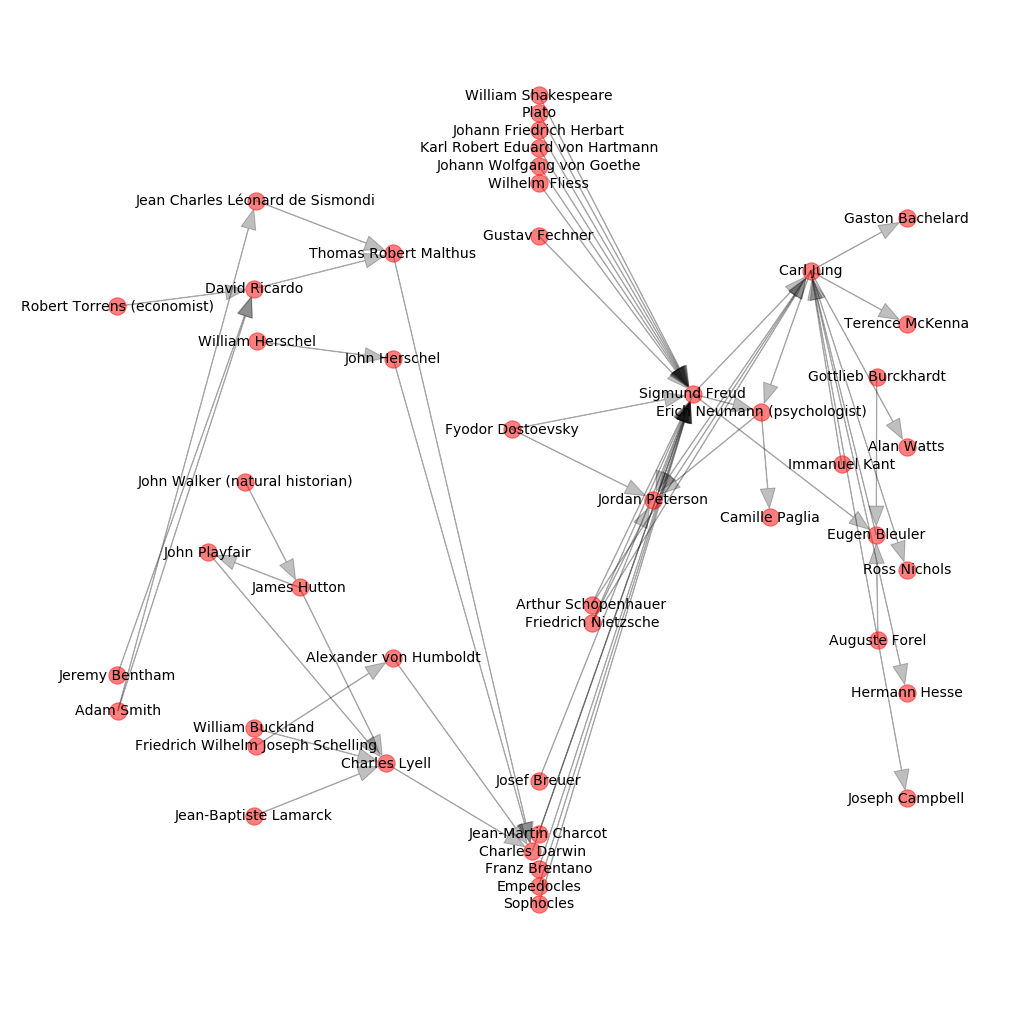

In [51]:

create_modified_kamada_kawai_plot(jung_digraph)

In [1]:
%%javascript
var kernel = IPython.notebook.kernel;
var body = document.body,  
    attribs = body.attributes;
var command = "notebook_path = " + "'"+attribs['data-notebook-path'].value+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [2]:
# %load ../../load_magic/nbviewer.py

from IPython.display import HTML

notebook_viewer_url = 'https://nbviewer.jupyter.org/github/dbabbitt/notebooks/blob/master/'
notebook_viewer_url += '/'.join(notebook_path.split('/')[1:])
HTML('Click <a href="' + notebook_viewer_url + '" target="_blank">here</a> to view notebook in nbviewer.')